# Intro Task, Object Localization 

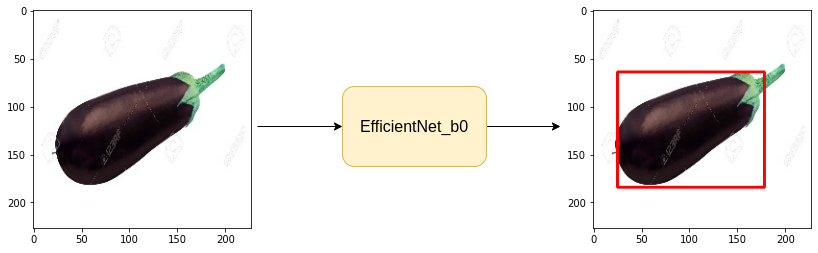

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-03019qx2
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-03019qx2
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=8cb454e97c945cd60493a47161e639d7204a7d07ed545c0e7b8a4b06bf76274e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_dr945fx/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR='/content/object-localization-dataset/'

DEVICE='cuda'
BATCH_SIZE =16
IMG_SIZE=140

LR=0.001
EPOCHS =40
MODEL_NAME ='efficientnet_b0'
NUM_COR=4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

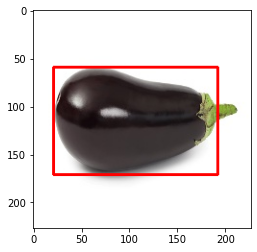

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1=(row.xmin, row.ymin)
pt2=(row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1,pt2,(255,0,0),2)
plt.imshow(img)

In [ ]:
train_df,valid_df=train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format ='pascal_voc',label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format ='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations =None):
    self.df=df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox=[[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
        data =self.augmentations(image =img, bboxes =bbox, class_labels=[None])
        img = data['image']
        bbox= data['bboxes'][0]

    img =torch.from_numpy(img).permute(2,0,1)/255.0  #(h,w,c) ->(c,h,w)
    bbox =torch.Tensor(bbox)

    return img, bbox




In [ ]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [ ]:
print(f"Total example in the trainset: {len(trainset)}")
print(f"Total example in the validset: {len(validset)}")

Total example in the trainset: 148
Total example in the validset: 38


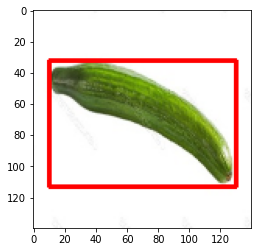

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle = True)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
      super(ObjLocModel, self).__init__()
      self.backbone = timm.create_model(MODEL_NAME,pretrained=True, num_classes=4)
  def forward(self, images, gt_bboxes=None):
      bboxes = self.backbone(images)

      if gt_bboxes !=None:
          loss=nn.MSELoss()(bboxes,gt_bboxes)
          return bboxes, loss
      return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
    total_loss =0.0
    model.train() # Dropout ON

    for data in tqdm(dataloader):
      images, gt_bboxes =data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      
      bboxes, loss = model(images, gt_bboxes)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader, optimizer):
    total_loss =0.0
    model.eval() # Dropout OFF

    with torch.no_grad():

        for data in tqdm(dataloader):
          images, gt_bboxes =data
          images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
          
          bboxes, loss = model(images, gt_bboxes)

 
          total_loss += loss.item()

        return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss =train_fn(model, trainloader, optimizer)
    valid_loss =eval_fn(model, validloader, optimizer)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss=valid_loss

    print(f"Epoch: {i+1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 train loss: 2091.283825683594 valid loss: 991.5921834309896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 train loss: 1172.9291259765625 valid loss: 406.81488037109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 3 train loss: 774.8622741699219 valid loss: 165.5823771158854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 train loss: 554.4092651367188 valid loss: 156.10108947753906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 train loss: 427.6162109375 valid loss: 221.96776835123697


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 train loss: 312.16065216064453 valid loss: 173.67852274576822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 train loss: 244.96248626708984 valid loss: 203.59657287597656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 train loss: 188.65924987792968 valid loss: 160.89051564534506


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 9 train loss: 136.40027465820313 valid loss: 148.80396525065103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 10 train loss: 143.57223815917968 valid loss: 105.7850112915039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 train loss: 110.78423156738282 valid loss: 119.87196350097656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 train loss: 103.02259788513183 valid loss: 133.62960052490234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 train loss: 100.79913940429688 valid loss: 120.98188018798828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 14 train loss: 99.14811973571777 valid loss: 80.58316548665364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 train loss: 91.83789443969727 valid loss: 96.200439453125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss: 79.05986938476562 valid loss: 85.70986366271973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss: 77.77539443969727 valid loss: 95.47793579101562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 train loss: 69.35811805725098 valid loss: 85.88641103108723


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 59.60924434661865 valid loss: 115.7293217976888


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss: 66.22284164428712 valid loss: 84.24725596110027


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 21 train loss: 71.2407054901123 valid loss: 62.60254796346029


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 62.27569351196289 valid loss: 94.40365346272786


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss: 60.20361175537109 valid loss: 67.24311701456706


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 24 train loss: 66.96818809509277 valid loss: 48.56156539916992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss: 50.448786926269534 valid loss: 57.27452596028646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss: 53.59212589263916 valid loss: 73.76155853271484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss: 60.51925106048584 valid loss: 72.51147842407227


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss: 59.36843986511231 valid loss: 66.76525624593098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss: 47.345289421081546 valid loss: 85.42311223347981


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 49.27152328491211 valid loss: 48.96462186177572


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss: 41.14813652038574 valid loss: 52.2223752339681


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 train loss: 54.87995204925537 valid loss: 69.77185440063477


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss: 51.50772399902344 valid loss: 62.159070332845054


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 55.313956069946286 valid loss: 75.0533053080241


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 41.56504726409912 valid loss: 65.7593879699707


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss: 42.07839794158936 valid loss: 62.53660329182943


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 44.24639053344727 valid loss: 97.44534556070964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss: 52.53105926513672 valid loss: 56.28670692443848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 49.49973430633545 valid loss: 94.29989878336589


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 38.066637420654295 valid loss: 63.140628814697266


#Inference

In [ ]:
import utils

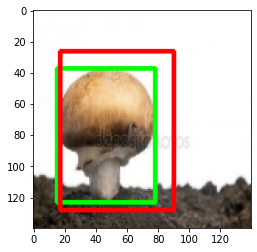

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[9] #(c,h,w)
    image = image.unsqueeze(0).to(DEVICE) #(bs, c, h, w)
    out_bbox = model(image)

    utils.compare_plots(image,gt_bbox, out_bbox)